# Environment

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load Data

## Fold Change

In [3]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [4]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,H2afy2,898.006083,-0.000002,0.096164,-0.000017,0.999986,0.999986
1,Lurap1l,248.853019,0.000021,0.175418,0.000119,0.999905,0.999970
2,Tcea1,1680.603269,0.000090,0.088197,0.001019,0.999187,0.999963
3,Igdcc4,872.289717,0.000126,0.100337,0.001255,0.998999,0.999963
4,Kdm6a,792.508606,-0.000035,0.108607,-0.000325,0.999741,0.999963


In [5]:
DEA_NEU.shape

(12945, 7)

In [6]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [7]:
print(DEA_NEU.shape)
print(DEA_NSC.shape)

(2115, 7)
(8908, 7)


In [8]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798


## Expression Binning

In [9]:
# Calculate quantiles for expression binning
q33, q66 = DEA_NEU['baseMean'].quantile([0.33, 0.66])

In [10]:
# Create a function to assign expression level
def get_expression_level(baseMean):
    if baseMean <= q33:
        return 'Low'
    elif baseMean <= q66:
        return 'Medium'
    else:
        return 'High'

In [11]:
# Add expression level column to DEA_NEU
DEA_NEU['expression_level'] = DEA_NEU['baseMean'].apply(get_expression_level)

In [12]:
# Let's see the distribution
print("Expression level boundaries:")
print(f"Low: baseMean <= {q33:.2f}")
print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
print(f"High: baseMean > {q66:.2f}")
print("\nNumber of genes in each category:")
print(DEA_NEU['expression_level'].value_counts())

Expression level boundaries:
Low: baseMean <= 866.41
Medium: 866.41 < baseMean <= 2189.20
High: baseMean > 2189.20

Number of genes in each category:
expression_level
High      719
Low       698
Medium    698
Name: count, dtype: int64


In [13]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,expression_level
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950,Low
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914,High
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914,High
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914,Low
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798,Low


## MECP2

In [14]:
mecp2_NEU = pd.read_csv("./DATA/allgenes_NEU.csv", header=0)
mecp2_NSC = pd.read_csv("./DATA/allgenes_NSC.csv", header=0)

In [15]:
print(mecp2_NEU.shape)
print(mecp2_NSC.shape)

(80, 6)
(467, 6)


In [16]:
mecp2_NEU.head()

,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Abcg2,230.797511,0.825216,UP,False,True
1,AW551984,581.286456,0.749896,UP,False,True
2,Bend5,155.132445,0.577849,UP,False,True
3,Cgn,176.027310,0.683605,UP,False,True
4,Crhr2,85.668042,0.805206,UP,False,True


# Plots

In [17]:
def volcano_plot_by_expression(df1, df2, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter', size=10):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    axes = {'Low': ax1, 'Medium': ax2, 'High': ax3}
    
    # Process each expression level
    for expression_level, ax in axes.items():
        # Filter data for current expression level
        df1_filtered = df1[df1['expression_level'] == expression_level]
        
        # Create mappings
        color_mapping = {}
        alpha_mapping = {}
        size_mapping = {}
        
        # Set default values
        for gene in df1_filtered['gene']:
            color_mapping[gene] = 'lightgrey'
            alpha_mapping[gene] = 0.3
            size_mapping[gene] = size
        
        # Override for genes found in df2
        for gene in df2['gene'].values:
            if gene in df1_filtered['gene'].values:
                if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                    if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                        color_mapping[gene] = 'green'
                        alpha_mapping[gene] = 0.8
                        size_mapping[gene] = 2*size
                    if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                        color_mapping[gene] = 'red'
                        alpha_mapping[gene] = 0.8
                        size_mapping[gene] = 2*size
        
        # Create color lists
        colors = [color_mapping[gene] for gene in df1_filtered['gene']]
        alphas = np.array([alpha_mapping[gene] for gene in df1_filtered['gene']])
        sizes = np.array([size_mapping[gene] for gene in df1_filtered['gene']])
        
        # Plot background points
        background_mask = np.array([c == 'lightgrey' for c in colors])
        ax.scatter(df1_filtered.loc[background_mask, 'log2FoldChange'],
                  df1_filtered.loc[background_mask, 'neg_log_pvalue'],
                  c='lightgrey',
                  alpha=alphas[background_mask],
                  s=sizes[background_mask])
        
        # Plot colored points
        colored_mask = np.array([c in ['red', 'green'] for c in colors])
        ax.scatter(df1_filtered.loc[colored_mask, 'log2FoldChange'],
                  df1_filtered.loc[colored_mask, 'neg_log_pvalue'],
                  c=[c for c, m in zip(colors, colored_mask) if m],
                  alpha=alphas[colored_mask],
                  s=sizes[colored_mask])
        
        # Configure subplot
        ax.set_xlabel('log2 Fold Change', fontsize=12)
        ax.set_ylabel('-log10(p-value)', fontsize=12)
        ax.set_title(f'{expression_level} Expression Genes', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add labels if requested
        if labels:
            pvalue_threshold = -np.log10(p_value_threshold)
            for idx, row in df1_filtered.iterrows():
                if (abs(row['log2FoldChange']) > fc_threshold) and (row['neg_log_pvalue'] > pvalue_threshold):
                    ax.annotate(row['gene'],
                              (row['log2FoldChange'], row['neg_log_pvalue']),
                              xytext=(5, 5),
                              textcoords='offset points',
                              fontsize=8)
    
    # Create common legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='red', label=f'{promoter_type} Enriched\n(Downregulated)', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='green', label=f'{promoter_type} Enriched\n(Upregulated)', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='lightgrey', label='Not in df2', markersize=7)
    ]
    
    fig.legend(handles=legend_elements, loc='center right')
    plt.tight_layout()
    
    return fig, axes



/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


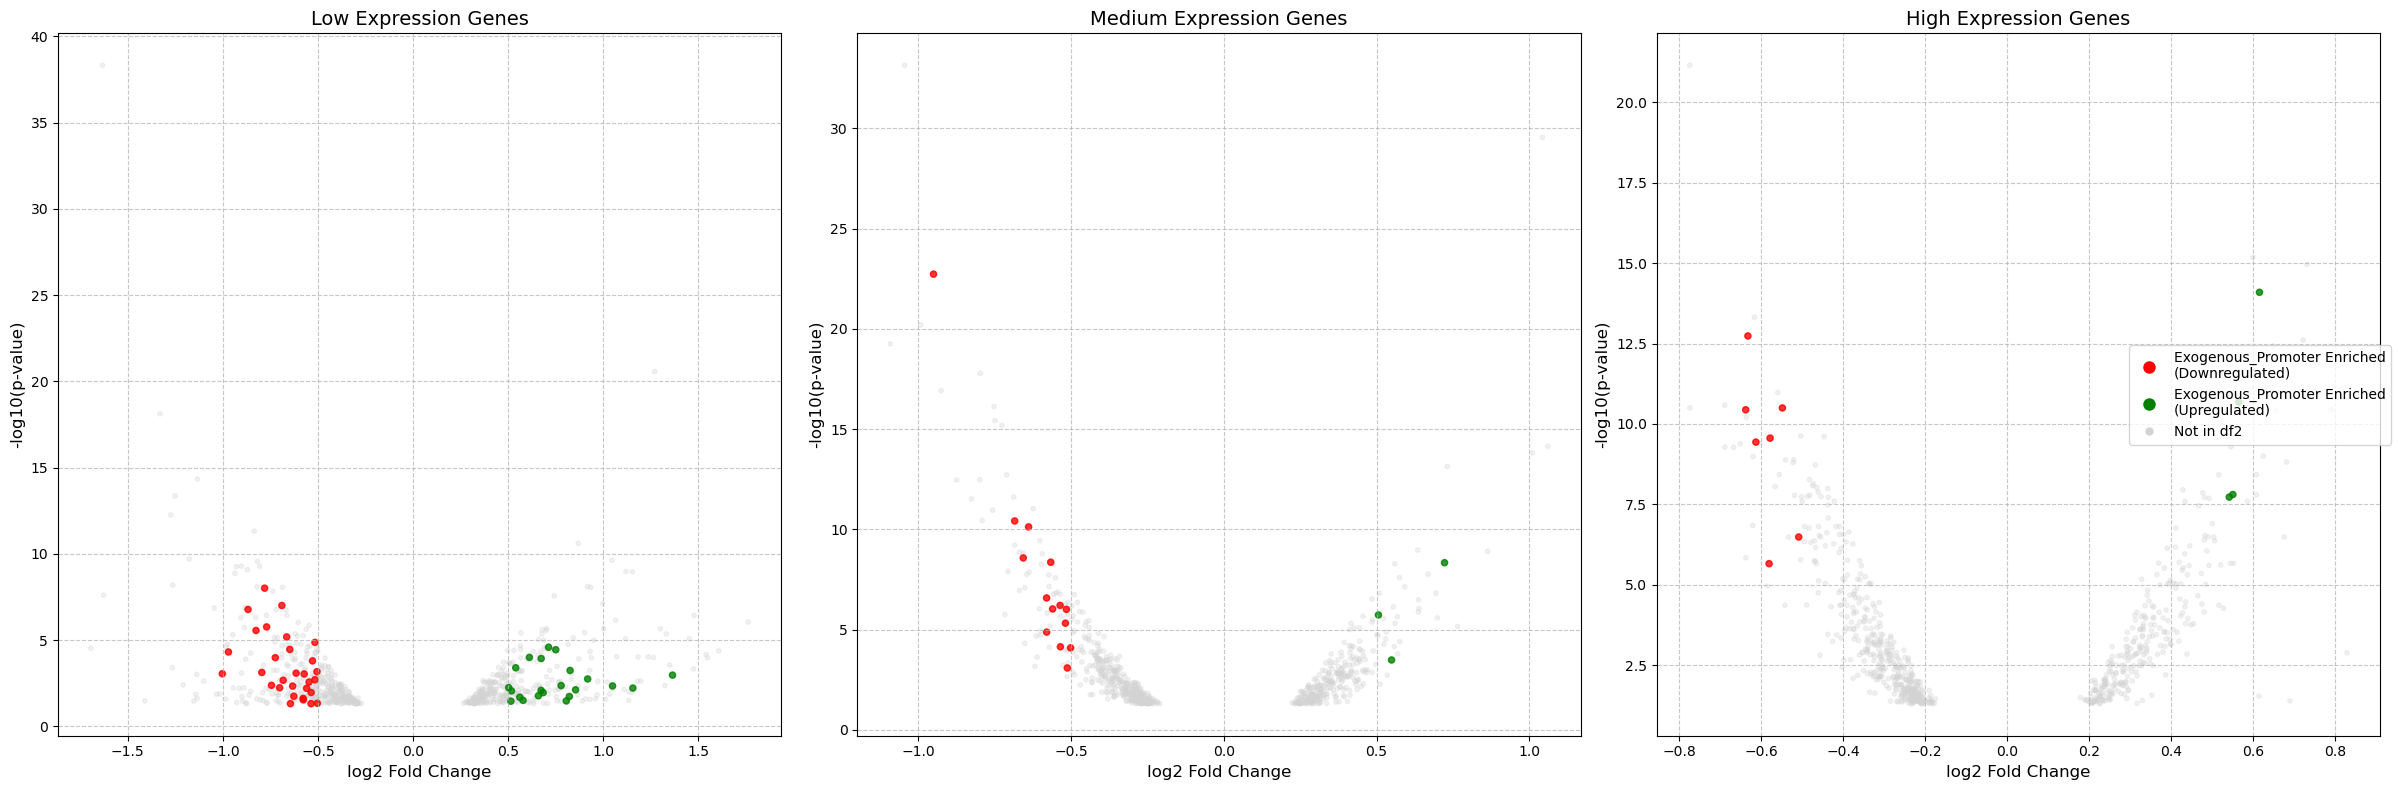

In [18]:
fig, axes = volcano_plot_by_expression(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=False)
plt.show()